In [1]:
import sys
!{sys.executable} -m pip install moviepy

In [2]:
from tqdm import tqdm
import mediapipe as mp
import os
import shutil
import json
import time
from util.ioUtil import *
import numpy as np
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt
import parselmouth
from IPython.display import Audio

In [3]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
landmark_output = []
tolerance = 0.001
file = "E:/ten_videos/grenade/grenade_3/frame176.jpg"
with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        min_detection_confidence=0.5) as face_mesh:
    imgs_arr = []
    image = cv2.imread(file)
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    face_landmarks = results.multi_face_landmarks[0].landmark
    land_mark_matrix_pts = np.zeros((468, 3))
    for i in range(0, len(face_landmarks)):
        land_mark_matrix_pts[i, 0] = face_landmarks[i].x
        land_mark_matrix_pts[i, 1] = face_landmarks[i].y
        land_mark_matrix_pts[i, 2] = face_landmarks[i].z
    plane_pts = [land_mark_matrix_pts[98], land_mark_matrix_pts[327], land_mark_matrix_pts[168]]
    # rotate the projected matrix to face the camerra
    n = np.cross(plane_pts[2] - plane_pts[1], plane_pts[0] - plane_pts[1])
    n = n / np.linalg.norm(n)
    R = rotation_matrix_from_vectors(n, np.array([0, 0, 1]))
    rotated_land_marks = np.expand_dims(land_mark_matrix_pts, axis=2)
    R = np.expand_dims(R, axis=0)
    rotated_land_marks = R @ rotated_land_marks
    projected_land_marks = rotated_land_marks[:, 0:2, 0]
    projected_land_marks = projected_land_marks - projected_land_marks[4]
    
    nose_ridge_vector = (projected_land_marks[6, :])
    nose_ridge_vector = nose_ridge_vector / np.linalg.norm(nose_ridge_vector)
    target_nose_ridge_direction = np.array([0, 1])
    abs_angle_diff = np.arccos(np.dot(nose_ridge_vector, target_nose_ridge_direction))
    theta = abs_angle_diff
    r = np.array(((np.cos(theta), -np.sin(theta)),
                  (np.sin(theta), np.cos(theta))))
    diff = np.linalg.norm(r @ nose_ridge_vector - target_nose_ridge_direction)
    if diff >= tolerance:
        theta = - theta
        r = np.array(((np.cos(theta), -np.sin(theta)),
                      (np.sin(theta), np.cos(theta))))
        if np.linalg.norm(r @ nose_ridge_vector - target_nose_ridge_direction) >= diff:
            theta = - theta
            r = np.array(((np.cos(theta), -np.sin(theta)),
                          (np.sin(theta), np.cos(theta))))

    normalized_landmark = np.expand_dims(r, axis=0) @ np.expand_dims(projected_land_marks, axis=2)
    landmark_output = normalized_landmark[:, :, 0]

In [5]:
print(landmark_output.shape)

(468, 2)


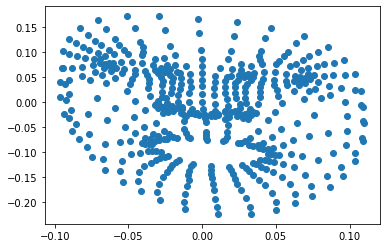

In [6]:
plt.scatter(landmark_output[:,0], landmark_output[:,1])
    # plt.scatter(landmark_arr_i[4, 0], landmark_arr_i[4, 1])
    # plt.scatter(landmark_arr_i[98, 0], landmark_arr_i[98, 1])
    # plt.scatter(landmark_arr_i[327, 0], landmark_arr_i[327, 1])
    # plt.show()
plt.show()

In [8]:
file_mediapipe = "E:/ten_videos/I_dont_love_you/I_dont_love_you_short/mediapipe_landmark.npy"
file_cv = "E:/ten_videos/I_dont_love_you/I_dont_love_you_short/cv_landmark.npy"

In [9]:
cv_arr = np.load(file_cv)
mp_arr = np.load(file_mediapipe)

In [10]:
cv_arr_mod = cv_arr/2

    

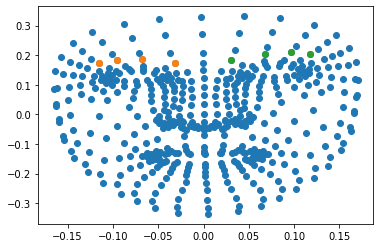

In [16]:
i = 0
right_eye_brows = [55, 65, 52, 53] # middle to side
left_eye_brows = [285, 295, 282, 283] # middle to side

# plt.scatter(cv_arr_mod[i,:,0], cv_arr_mod[i,:,1])
plt.scatter(mp_arr[i,:,0], mp_arr[i,:,1])
plt.scatter(mp_arr[i,left_eye_brows,0], mp_arr[i,left_eye_brows,1])
plt.scatter(mp_arr[i,right_eye_brows,0], mp_arr[i,right_eye_brows,1])

plt.show()

In [3]:
# upper_lip_top = 0
def get_lip_shapes(mp_arr):
    upper_lip_bottom = 13
    lower_lip_top = 14
    # lower_lip_bottom = 17
    left_lip = 292
    right_lip = 62

    lip_parameters = [upper_lip_bottom, lower_lip_top, left_lip, right_lip]
    vertical_openning = np.linalg.norm(mp_arr[:,lip_parameters[0]] - mp_arr[:,lip_parameters[1]], axis=1)
    vertical_openning = (vertical_openning - vertical_openning.min())/(vertical_openning.max() - vertical_openning.min())
    horizontal_openning = np.linalg.norm(mp_arr[:,lip_parameters[2]] - mp_arr[:,lip_parameters[3]], axis=1)
    horizontal_openning = (horizontal_openning - horizontal_openning.min())/(horizontal_openning.max() - horizontal_openning.min())
    return [vertical_openning, horizontal_openning]

In [58]:
v_opening, h_opening = get_lip_shapes(mp_arr)


In [8]:
landmarks_path = "E:/ten_videos/Child_in_time/Child_in_time_2/mediapipe_landmark.npy"
land_marks = np.load(landmarks_path)
adele_v_arr, adele_h_arr = get_lip_shapes(land_marks)

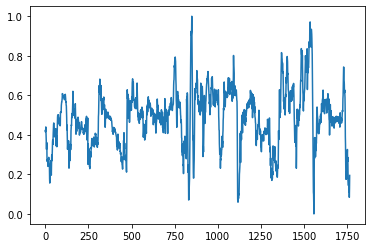

In [7]:
plt.plot(adele_h_arr)
plt.show()

# align the Jaw-lip tracking clip of two different lengths

In [73]:
def align2clips(clip1, clip2):
    # clip1 should be the shorter clip
    diff = clip2.shape[0] - clip1.shape[0]
    min_val = np.inf
    min_index = -1
    for i in range(0, diff):
        temp_aligned_clip2 = clip2[i:i + clip1.shape[0]]
        val = np.linalg.norm(temp_aligned_clip2 - clip1)
        if val <= min_val:
            min_val = val
            min_index = i
    return clip2[min_index:min_index + clip1.shape[0]]
        
    

568


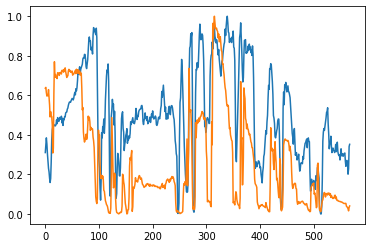

In [77]:
aligned_jali = align2clips(adele_v_arr, jali_v_arr)
plt.plot(adele_v_arr)
plt.plot(aligned_jali)
plt.show()

# Silence Detection

In [87]:
from pydub import AudioSegment,silence

myaudio = intro = AudioSegment.from_mp3("/Volumes/EVAN_DISK/ten_videos/Child_in_time/Child_in_time_1/audio.mp3")
dBFS=myaudio.dBFS
silence = silence.detect_silence(myaudio, min_silence_len=100, silence_thresh=dBFS-16)

silence = [((start/1000),(stop/1000)) for start,stop in silence] #in sec
print(silence)


[(0.0, 0.636), (1.229, 1.4), (3.836, 4.868), (7.773, 9.138), (11.916, 13.338), (15.674, 17.066), (20.243, 20.975), (24.232, 25.298), (27.771, 28.975), (32.02, 32.54)]


# Pitch Detection with Lip Detection

In [4]:
snd = parselmouth.Sound("E:/ten_videos/Child_in_time/Child_in_time_2/audio.mp3")

In [35]:
time_step = 0.05
pitch = snd.to_pitch(time_step = time_step, pitch_ceiling = 2000)
intensity = snd.to_intensity(time_step=time_step)

In [36]:
def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")
    
# upper_lip_top = 0
def get_lip_shapes(mp_arr):
    upper_lip_bottom = 13
    lower_lip_top = 14
    # lower_lip_bottom = 17
    left_lip = 292
    right_lip = 62

    lip_parameters = [upper_lip_bottom, lower_lip_top, left_lip, right_lip]
    vertical_openning = np.linalg.norm(mp_arr[:,lip_parameters[0]] - mp_arr[:,lip_parameters[1]], axis=1)
    vertical_openning = (vertical_openning - vertical_openning.min())/(vertical_openning.max() - vertical_openning.min())
    horizontal_openning = np.linalg.norm(mp_arr[:,lip_parameters[2]] - mp_arr[:,lip_parameters[3]], axis=1)
    horizontal_openning = (horizontal_openning - horizontal_openning.min())/(horizontal_openning.max() - horizontal_openning.min())
    return [vertical_openning, horizontal_openning]

In [37]:
landmarks_path = "E:/ten_videos/Child_in_time/Child_in_time_2/mediapipe_landmark.npy"
land_marks = np.load(landmarks_path)
v_arr, h_arr = get_lip_shapes(land_marks)

29.97002997002997


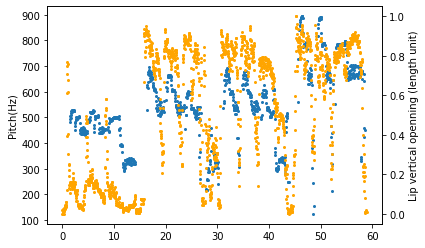

In [91]:
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

pitch_values = pitch.selected_array['frequency']
pitch_values[pitch_values>=1000] = np.nan
pitch_values[pitch_values==0] = np.nan
ax_left.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
ax_left.plot(pitch.xs(), pitch_values, 'o', markersize=2)
ax_left.set_ylabel("Pitch(Hz)")
ax_right.set_ylabel("Lip vertical openning (length unit)")
ax_left.grid(False)
# plt.ylim(0, pitch.ceiling)
with open("E:/ten_videos/Child_in_time/Child_in_time_2/other_info.json") as f:
    fps_video = json.load(f)["fps"]
print(fps_video)
time = 0;
lip_xs = []
for i in range(0, len(v_arr)):
    time = time + 1/fps_video
    lip_xs.append(time)

# ax_left.plot(left_data, color='black')
ax_right.plot(np.array(lip_xs), v_arr, 'o', markersize=2, color = "orange")

## Trying to clear the outliers from the pitch prediction data

In [78]:
# pitch_values = pitch.selected_array['frequency']
# print(pitch_values.shape)
# window_size = 1.5 # 2 seconds
# time_step = time_step
# feasible_range = 400

# window_size_step = int(window_size/time_step)
# for i in range(0, pitch_values.shape[0] - window_size_step, int(window_size_step/2)):
#     sub_pitch = pitch_values[i:i+window_size_step]
#     med = np.median(sub_pitch)
#     for k in range(0, sub_pitch.shape[0]):
#         if sub_pitch[k] > med + feasible_range or sub_pitch[k] < med - feasible_range:
#             print(sub_pitch[k])
#             pitch_values[i + k] = np.nan

## Compare the lower pitch and the higher Pitch segment

In [92]:
Ah_low = [16.46, 26.99]
Ah_high = [44.81, 58.69]

In [1]:
def get_index_of_interval(interval, xs):
    x_vals_low = [-1, -1]
    for i in range(0, xs.shape[0]):
#         x_vals_low.append(xs[i])
        if xs[i] >= interval[0]:
            x_vals_low[0] = i
            break
    for i in range(0, xs.shape[0]):
#         x_vals_low.append(xs[i])
        if xs[i] <= interval[1] and x_vals_low[0] != -1:
            x_vals_low[1] = i
    print(x_vals_low)
    return x_vals_low

In [120]:
low_interval_pitch = get_index_of_interval(Ah_low, pitch.xs())
low_interval_jaw = get_index_of_interval(Ah_low, np.array(lip_xs))

[329, 539]
[493, 807]


29.97002997002997


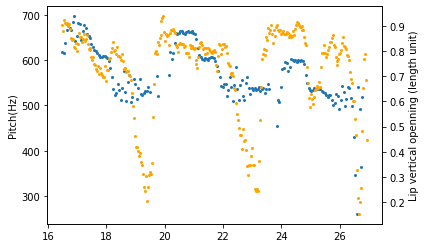

In [125]:
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
pitch_values = pitch.selected_array['frequency'][low_interval_pitch[0]:low_interval_pitch[1]]
pitch_values[pitch_values>=1000] = np.nan
pitch_values[pitch_values==0] = np.nan

ax_left.plot(pitch.xs()[low_interval_pitch[0]:low_interval_pitch[1]], pitch_values, 'o', markersize=5, color='w')
ax_left.plot(pitch.xs()[low_interval_pitch[0]:low_interval_pitch[1]], pitch_values, 'o', markersize=2)
ax_left.set_ylabel("Pitch(Hz)")
ax_right.set_ylabel("Lip vertical openning (length unit)")
ax_left.grid(False)
# plt.ylim(0, pitch.ceiling)
with open("E:/ten_videos/Child_in_time/Child_in_time_2/other_info.json") as f:
    fps_video = json.load(f)["fps"]
print(fps_video)
time = 0;
lip_xs = []
for i in range(0, len(v_arr)):
    time = time + 1/fps_video
    lip_xs.append(time)

# ax_left.plot(left_data, color='black')
ax_right.plot(np.array(lip_xs)[low_interval_jaw[0]:low_interval_jaw[1]], v_arr[low_interval_jaw[0]:low_interval_jaw[1]], 'o', markersize=2, color = "orange")

[896, 1173]
[1342, 1757]
29.97002997002997


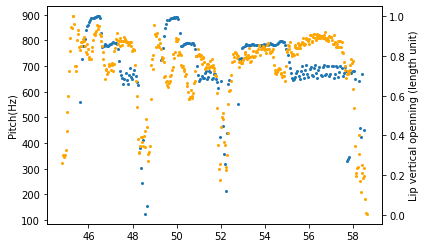

In [126]:
low_interval_pitch = get_index_of_interval(Ah_high, pitch.xs())
low_interval_jaw = get_index_of_interval(Ah_high, np.array(lip_xs))

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
pitch_values = pitch.selected_array['frequency'][low_interval_pitch[0]:low_interval_pitch[1]]
pitch_values[pitch_values>=1000] = np.nan
pitch_values[pitch_values==0] = np.nan

ax_left.plot(pitch.xs()[low_interval_pitch[0]:low_interval_pitch[1]], pitch_values, 'o', markersize=5, color='w')
ax_left.plot(pitch.xs()[low_interval_pitch[0]:low_interval_pitch[1]], pitch_values, 'o', markersize=2)
ax_left.set_ylabel("Pitch(Hz)")
ax_right.set_ylabel("Lip vertical openning (length unit)")
ax_left.grid(False)
# plt.ylim(0, pitch.ceiling)
with open("E:/ten_videos/Child_in_time/Child_in_time_2/other_info.json") as f:
    fps_video = json.load(f)["fps"]
print(fps_video)
time = 0;
lip_xs = []
for i in range(0, len(v_arr)):
    time = time + 1/fps_video
    lip_xs.append(time)

# ax_left.plot(left_data, color='black')
ax_right.plot(np.array(lip_xs)[low_interval_jaw[0]:low_interval_jaw[1]], v_arr[low_interval_jaw[0]:low_interval_jaw[1]], 'o', markersize=2, color = "orange")

[1342, 1757]
[493, 807]


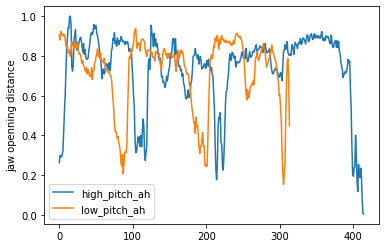

In [133]:
high_interval_jaw = get_index_of_interval(Ah_high, np.array(lip_xs))
lip_opening_high = v_arr[high_interval_jaw[0]:high_interval_jaw[1]]

low_interval_jaw = get_index_of_interval(Ah_low, np.array(lip_xs))
lip_opening_low = v_arr[low_interval_jaw[0]:low_interval_jaw[1]]

plt.plot(lip_opening_high, label="high_pitch_ah")
plt.plot(lip_opening_low, label="low_pitch_ah")
plt.ylabel("jaw openning distance")
plt.legend()